### This notebook uses the observed spectra, the estimated template, the detected absorption features, and the Gaussian fit parameters for each feature to perform the HGRV method.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from spectra_functions import wave_match
from astropy.io import fits

In [2]:
%matplotlib notebook

In [3]:
#define a function that gives the generalized 1st-degree Hermite-Gaussian function
def HG1(x, mu, sig):
    return 2*((x-mu)/sig)*np.exp(-((x - mu)**2)/(2*sig**2))/np.sqrt(sig*2*np.sqrt(np.pi))

In [4]:
template = pd.read_csv("217014smoothtemp.csv")
Features = pd.read_csv("GoodFeatures.csv")

In [5]:
filenames = [f for f in glob.glob("*ctd.csv")]
SPECTRA = [pd.read_csv(f) for f in filenames]
filenames2 = [f.split('ctd')[0] + ".fits" for f in filenames]

In [7]:
import datetime
daynum = []
for f in filenames2:
    spectrum = fits.open(f)[0]
    time = spectrum.header["MIDPOINT"]
    yr = int(time.split('-')[0])
    mth = int(time.split('-')[1])
    dy = int(time.split('-')[2].split('T')[0])
    h = int(time.split('T')[1].split(':')[0])+12
    mnt = int(time.split(':')[1])
    sec = int(time.split(':')[2].split('.')[0])
    delta = (datetime.datetime(year=yr, month=mth, day=dy, hour=h, minute=mnt, second=sec) - datetime.datetime(year=2019, month=6, day=5))
    daynum.append(delta.days + delta.seconds/(24*60*60))
daynum = daynum + 58638.498728

### Limit observed spectrum to the wavelengths at which the estimated template is defined

In [34]:
pxlspc = template.Wavelength.values[1:] - template.Wavelength.values[:-1]
jmps = np.where(pxlspc > 0.015)[0]
lbnds = np.array([template.Wavelength.values[0]] + list(template.Wavelength.values[jmps]))
ubnds = np.array(list(template.Wavelength.values[jmps+1]) + [template.Wavelength.values[-1]])

owvl = np.array([])
oflx = np.array([])
ounc = np.array([])
for i in range(len(lbnds)):
    w = np.where((SPECTRA[0].Wavelength.values >= lbnds[i]) & (SPECTRA[0].Wavelength.values <= ubnds[i]))[0]
    owvl = np.hstack((owvl, SPECTRA[0].Wavelength.values[w]))
    oflx = np.hstack((oflx, SPECTRA[0].Flux.values[w]))
    ounc = np.hstack((ounc, SPECTRA[0].Uncertainty.values[w]))

<IPython.core.display.Javascript object>


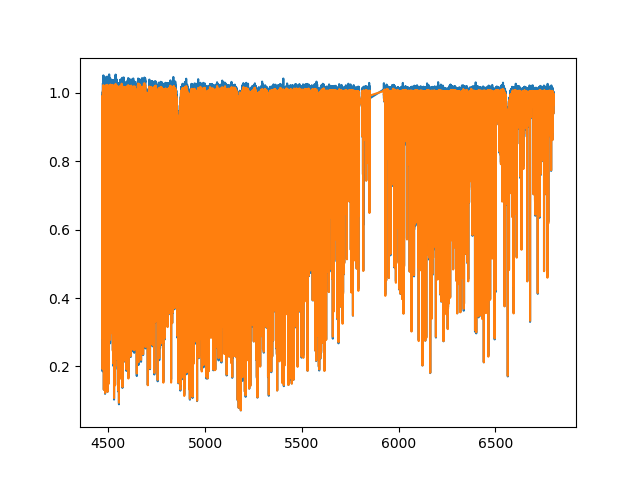

In [36]:
nonnans1 = np.where((~np.isnan(template.Flux.values)) & (template.Wavelength.values <= 7800 + 1) &
                   (template.Wavelength.values >= 4470 - 1))[0]
nonnans2 = np.where((~np.isnan(oflx)) & (owvl <= 7800) & 
                   (owvl >= 4470) &
                   ((owvl < 5851.3) | (owvl > 5923.7)) &
                   ((owvl < 5795.4) | (owvl > 5811.7)))[0]


wvl = owvl[nonnans2]
ounc = ounc[nonnans2]
oflx = oflx[nonnans2]
tflx = wave_match2(template.Wavelength.values[nonnans1], template.Flux.values[nonnans1], wvl)
plt.plot(wvl, oflx)
plt.plot(wvl, tflx)
plt.show()

<IPython.core.display.Javascript object>


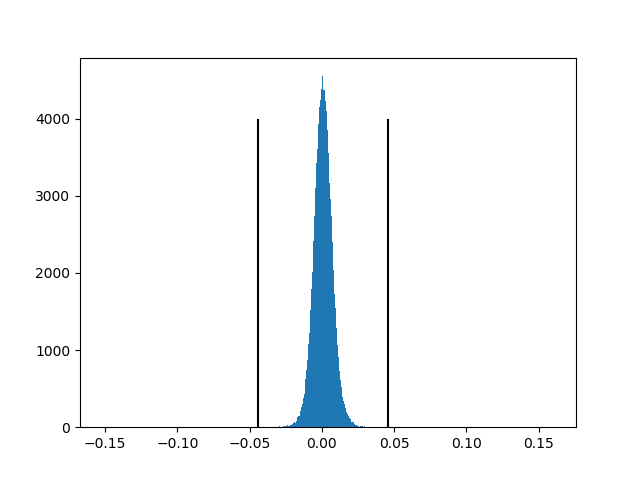

In [37]:
#mask out a few pixels that have extreme values for the difference flux
iqr = np.percentile(oflx-tflx, 75) - np.percentile(oflx-tflx, 25)
upper = np.percentile(oflx-tflx, 75) + 5*iqr
lower = np.percentile(oflx-tflx, 25) - 5*iqr
plt.hist(oflx-tflx, bins=1000)
plt.vlines([upper, lower], ymin=0, ymax=4000)
plt.show()

In [38]:
gd = np.where((oflx-tflx > lower) & (oflx-tflx < upper))[0]
wvl = wvl[gd]
oflx = oflx[gd]
tflx = tflx[gd]
ounc = ounc[gd]

In [1]:
#plt.rc('text', usetex=True)
#plt.gcf().subplots_adjust(bottom=0.18)
#plt.plot(wvl, oflx-tflx)
#plt.text(4900, 0.1, r"4850 \AA", fontsize=14)
#plt.text(6400, 0.1, r"6800 \AA", fontsize=14)
#plt.vlines([4850, 6800], -0.1, 0.1, linestyle='--')
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.xlabel(r"Wavelength (\AA)", fontsize=14)
#plt.ylabel(r"Difference Flux", fontsize=14)
#plt.savefig("DiffSpec")
#plt.show()

## Construct the explanatory HGRV variable

In [39]:
hgflux = np.zeros(len(wvl))
mFeatures = Features[(Features.Wv_lbounds.values >= wvl[0]) & (Features.Wv_ubounds.values <= wvl[-1])]
for i in range(len(mFeatures.Wv_lbounds.values)):
    #only update the values corresponding to wavelengths within 2 angstroms of the wavelength bounds
    w = np.where((wvl >= mFeatures.Wv_lbounds.values[i] - 2) & (wvl <= mFeatures.Wv_ubounds.values[i] + 2))[0]
    coef = np.sqrt(np.sqrt(np.pi))*mFeatures.Gauss_amp.values[i]*mFeatures.Gauss_mu.values[i]/(299792458*np.sqrt(2*mFeatures.Gauss_sig.values[i]))
    hgflux[w] = hgflux[w] + coef*HG1(wvl[w], mFeatures.Gauss_mu.values[i], mFeatures.Gauss_sig.values[i])

<IPython.core.display.Javascript object>


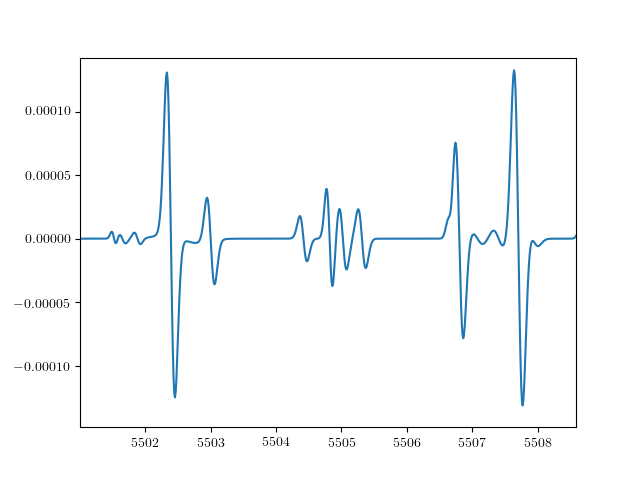

In [26]:
plt.plot(wvl, hgflux)
plt.show()

<IPython.core.display.Javascript object>


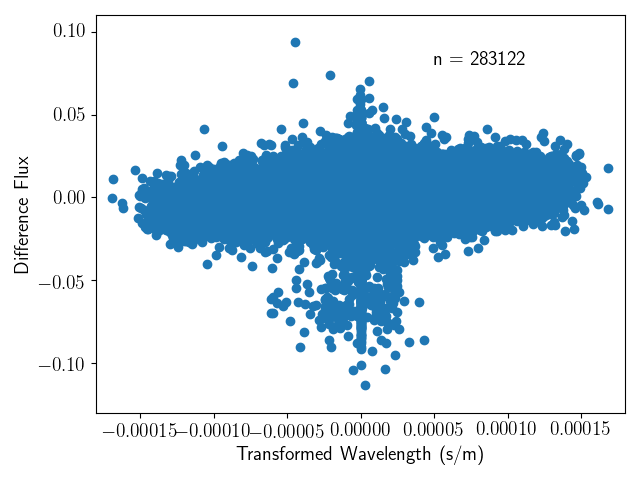

In [19]:
plt.scatter(hgflux, oflx-tflx)
plt.xlim(-0.00018, 0.00018)
plt.ylim(-0.13, 0.11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Transformed Wavelength (s/m)", fontsize=14)
plt.ylabel("Difference Flux", fontsize=14)
plt.text(0.00005, 0.08, "n = %d"%len(hgflux), fontsize=14)
plt.tight_layout()
plt.savefig("DiffSpec_model2")
plt.show()

In [40]:
#limit only to wavelengths inside of absorption features that were well fit with a Gaussian
keep = []
mFeatures = mFeatures.sort_values(by="Wv_lbounds")
maximum = 4850
for i in range(len(mFeatures.Wv_lbounds.values)):
    w = np.where((wvl > np.max([maximum, mFeatures.Wv_lbounds.values[i]])) & 
                 (wvl <= mFeatures.Wv_ubounds.values[i]))[0]
    keep = keep + list(w)
print(len(keep), len(wvl))

93848 216665


## Perform simple (weighted) linear regression without an intercept

In [41]:
#get the estimated RV
diff = oflx[keep]-tflx[keep]
wdiff = diff/ounc[keep]
whgflux = hgflux[keep]/ounc[keep]
rv_hat = np.sum(wdiff*whgflux)/np.sum(whgflux**2)
rv_hat

In [46]:
#get the standard error of the estimated RV
resid = wdiff - rv_hat*whgflux
var_hat = np.sum(resid*resid)/(len(resid)-1)
rv_hat_sd = np.sqrt(var_hat/np.sum(whgflux**2))
rv_hat_sd

0.5156251373708008

<IPython.core.display.Javascript object>


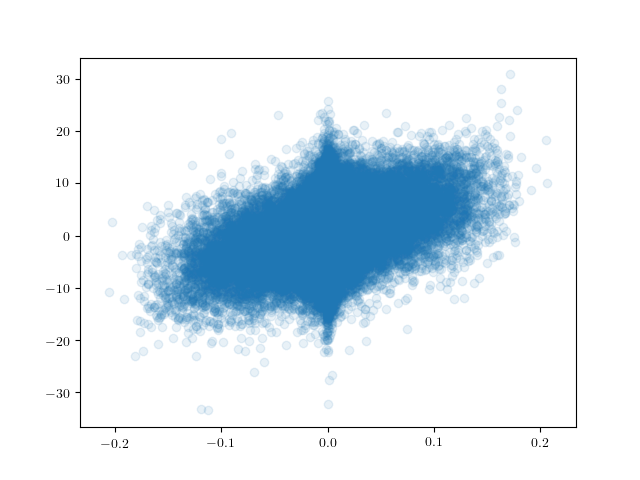

In [52]:
plt.scatter(whgflux, wdiff, alpha=0.1)
plt.show()

<IPython.core.display.Javascript object>


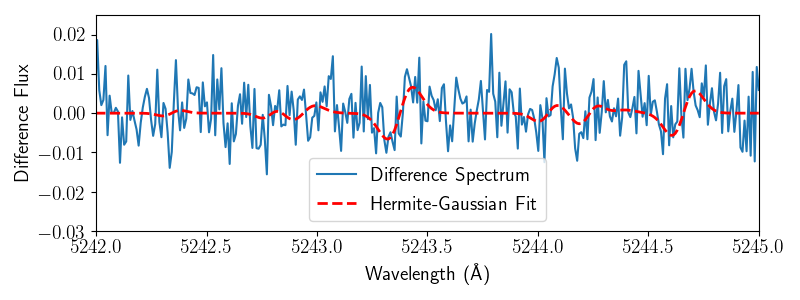

In [48]:
plt.figure(figsize=(8,3))
plt.rc('text', usetex=True)
plt.plot(wvl, oflx - tflx, label='Difference Spectrum')
plt.plot(wvl, rv_hat*hgflux, ls='--', lw=2, c='red', label='Hermite-Gaussian Fit')
plt.xlim(5242, 5245)
plt.ylim(-0.03, 0.025)
plt.legend(loc='best', fontsize=14, )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"Wavelength (\AA)", fontsize=14)
plt.ylabel(r"Difference Flux", fontsize=14)
plt.tight_layout()
plt.savefig("DiffSpec_model")
plt.show()

In [54]:
#perform the method on all observed spectra
rvs = []
rv_sds = []
for tau in range(len(SPECTRA)):
    owvl = np.array([])
    oflx = np.array([])
    ounc = np.array([])
    for i in range(len(lbnds)):
        w = np.where((SPECTRA[tau].Wavelength.values >= lbnds[i]) & (SPECTRA[tau].Wavelength.values <= ubnds[i]))[0]
        owvl = np.hstack((owvl, SPECTRA[tau].Wavelength.values[w]))
        oflx = np.hstack((oflx, SPECTRA[tau].Flux.values[w]))
        ounc = np.hstack((ounc, SPECTRA[tau].Uncertainty.values[w]))
    nonnans2 = np.where((~np.isnan(oflx)) & (owvl <= 7800) & 
                   (owvl >= 4470) &
                   ((owvl < 5851.3) | (owvl > 5923.7)) &
                   ((owvl < 5795.4) | (owvl > 5811.7)))[0]
    wvl = owvl[nonnans2]
    ounc = ounc[nonnans2]
    oflx = oflx[nonnans2]
    tflx = wave_match2(template.Wavelength.values[nonnans1], template.Flux.values[nonnans1], wvl)
    
    iqr = np.percentile(oflx-tflx, 75) - np.percentile(oflx-tflx, 25)
    upper = np.percentile(oflx-tflx, 75) + 5*iqr
    lower = np.percentile(oflx-tflx, 25) - 5*iqr
    gd = np.where((oflx-tflx > lower) & (oflx-tflx < upper))[0]
    wvl = wvl[gd]
    oflx = oflx[gd]
    tflx = tflx[gd]
    ounc = ounc[gd]
    
    hgflux = np.zeros(len(wvl))
    mFeatures = Features[(Features.Wv_lbounds.values >= wvl[0]) & (Features.Wv_ubounds.values <= wvl[-1])]
    for i in range(len(mFeatures.Wv_lbounds.values)):
        w = np.where((wvl >= mFeatures.Wv_lbounds.values[i] - 2) & (wvl <= mFeatures.Wv_ubounds.values[i] + 2))[0]
        coef = np.sqrt(np.sqrt(np.pi))*mFeatures.Gauss_amp.values[i]*mFeatures.Gauss_mu.values[i]/(299792458*np.sqrt(2*mFeatures.Gauss_sig.values[i]))
        hgflux[w] = hgflux[w] + coef*HG1(wvl[w], mFeatures.Gauss_mu.values[i], mFeatures.Gauss_sig.values[i])
    
    keep = []
    maximum = 4850
    for i in range(len(mFeatures.Wv_lbounds.values)):
        w = np.where((wvl > np.max([maximum, mFeatures.Wv_lbounds.values[i]])) & 
                     (wvl <= mFeatures.Wv_ubounds.values[i]))[0]
        keep = keep + list(w)
    diff = oflx[keep]-tflx[keep]
    wdiff = diff/ounc[keep]
    whgflux = hgflux[keep]/ounc[keep]
    rvs.append(np.sum(wdiff*whgflux)/np.sum(whgflux**2))
    resid = wdiff - rv_hat*whgflux
    var_hat = np.sum(resid*resid)/(len(resid)-1)
    rv_sds.append(np.sqrt(var_hat/np.sum(whgflux**2)))
    print(rvs[-1], rv_sds[-1])

52.84962423301899 0.515625137370801
53.66163707056566 0.7095141407216315
-46.57415290185085 0.521049585642068
-33.53564380002902 0.5119245211439701
43.41094150693174 0.443877713323361
42.24109112849054 0.4379259723700469
-48.08170105774514 0.505269957776809
-48.71112955837628 0.49845099363917567
53.09208409943924 0.4737394105186996
53.741281126581626 0.4863230755960278
-14.3168232857144 1.1302469885597473
-16.403446885111645 0.4313385085125802
-16.51504869431092 0.5186153378250195
-53.335794581343045 0.6525417928661322
-52.695701053923166 0.6668972517021893
4.267547094982808 0.45925195307252215
4.148183405873669 0.4532020319565319
-11.483751883895222 0.7060780549591887
-11.791874423339717 0.6234374959176762
54.614257857544786 0.36133325869616034
53.959229846844664 0.3427966732455844
53.689505742775886 0.3412916213257542
54.9583979747288 0.32986765311337274
54.357279274319644 0.3503438199073326
-36.33495869085266 1.1706597807608168
-35.866228250859365 1.2698623191545653
-43.918546992239

In [ ]:
RVdf = pd.DataFrame({"MJD": daynum, "Filename": filenames2, "RV": rvs, "RV_std": rv_sds})
RVdf.to_csv("Derived_RVs.csv")

# Model the RV over time with a sine curve

In [ ]:
RP = pd.read_csv("RP_results.txt", delim_whitespace = True) #RVs from Petersburg et al (2020)
RVS = pd.read_csv("Derived_RVs.csv")  #RVs from the HGRV method

In [ ]:
#Remove times observed in HGRV method but not in Petersburg et al. (2020)
diff_ph = np.array([2,11,15,18,19,25,26,27,29])
RVS = RVS.iloc[np.setdiff1d(np.arange(RVS.shape[0]), diff_ph)]

In [ ]:
from scipy.optimize import curve_fit
def indicator(x, step, rtn=0):
    out = np.zeros(len(x))
    above = np.where(x >= step)[0]
    out[above] = np.abs(1-rtn)
    below = np.setdiff1d(np.arange(len(x)), above)
    out[below] = np.abs(0-rtn)
    return out
def nonlinfunc2(z, a, b1, b2, c, d):
    return c*np.sin(2*np.pi*z/d - a) + b1*indicator(z, 80) + b2*indicator(z, 80, rtn=1)
params, cov = curve_fit(nonlinfunc2, RVS.MJD.values - RVS.MJD.values[0], RVS.RV.values, p0=(0, 0, 0, 55.9, 4.23))
params2, cov2 = curve_fit(nonlinfunc2, RP.BMJD.values - RP.BMJD.values[0], (RP.V_CCF.values - np.mean(RP.V_CCF.values))/100, 
                                                                            p0=(0, 0, 0, 55.9, 4.23))
params3, cov3 = curve_fit(nonlinfunc2, RP.BMJD.values - RP.BMJD.values[0], (RP.V_FM.values - np.mean(RP.V_FM.values))/100, 
                                                                            p0=(0, 0, 0, 55.9, 4.23))

### HGRV results:

In [ ]:
params

In [ ]:
np.sqrt(np.diag(cov))

### CCF results:

In [ ]:
params2

In [ ]:
np.sqrt(np.diag(cov2))

### FM results:

In [ ]:
params3

In [ ]:
np.sqrt(np.diag(cov3))

## Compare the overall RMS of the three methods

In [ ]:
fitted = nonlinfunc2(RVS.MJD.values - RVS.MJD.values[0], params[0], params[1], params[2], params[3], params[4])
print("HGRV: ", np.sqrt(np.mean((fitted - RVS.RV.values)**2)))
fitted2 = nonlinfunc2(RP.BMJD.values - RP.BMJD.values[0], params2[0], params2[1], params2[2], params2[3], params2[4])
print("CCF: ", np.sqrt(np.mean((fitted2 - (RP.V_CCF.values - np.mean(RP.V_CCF.values))/100)**2)))
fitted3 = nonlinfunc2(RP.BMJD.values - RP.BMJD.values[0], params3[0], params3[1], params3[2], params3[3], params3[4])
print("FM: ", np.sqrt(np.mean((fitted3 - (RP.V_FM.values - np.mean(RP.V_FM.values))/100)**2)))

## Analyze the correlation of the fitted parameters in the HGRV method.

In [ ]:
Dinv = np.linalg.inv(np.diag(np.sqrt(np.diag(cov))))
R = np.dot(np.dot(Dinv, cov), Dinv)
R